# 1. Import datasets

### 1.1 Dataset with images

In [23]:
files = ! dir phase_images
files = [_.split('           ')[-1][8:] for _ in files if ('.png' in _)]

labels = []
for __ in range(len(files)):
    try:
        labels.append([float(_) for _ in files[__].split('[')[-1].split(']')[0].split(' ') if len(_) > 1])
    except:
        print('Error', __)

import numpy as np
np.set_printoptions(precision=5)
sample_of_labels = np.random.randint(0, len(labels), 60000)
labels = np.array(labels)[sample_of_labels]

In [24]:
len(files)

97417

In [25]:
labels

array([[ 5.4671,  2.8576],
       [-4.554 ,  5.3804],
       [ 0.8749,  2.2187],
       ...,
       [-4.8812, -5.9822],
       [-2.4223,  4.6961],
       [ 2.619 , -4.3812]])

In [34]:
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

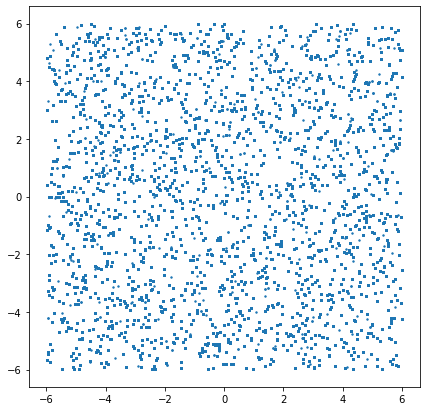

In [118]:
plt.figure(figsize=(7,7))
plt.scatter(labels[:,0], labels[:,1], s=2)

(160, 160)


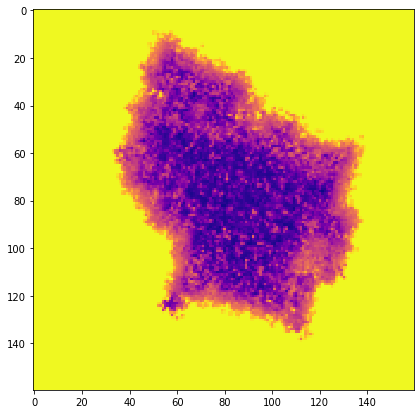

In [75]:
IMAGE_SIZE = 300
PADDING = 70

pil_im = Image.open('phase_images/'+files[np.random.randint(0, len(files))])
pil_im.thumbnail((IMAGE_SIZE, IMAGE_SIZE))
pil_im = pil_im.convert('L')
plt.figure(figsize=(7,7))
pil_im = np.array(pil_im)[PADDING:-PADDING,PADDING:-PADDING]
print(pil_im.shape)
pil_im = Image.fromarray(pil_im)
plt.imshow(pil_im, cmap='plasma')
plt.show();

### 1.2 Dataset with Voronoi diagrams

In [29]:
voronoi_files = ! dir Voronoi_diagrams
voronoi_files = [_.split('           ')[-1][8:] for _ in voronoi_files if ('.png' in _)]
voronoi_points = np.load('Voronoi_diagrams/production_points.npy')

voronoi_idx 58


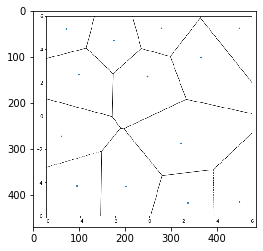

In [30]:
#voronoi_idx = np.random.randint(0, len(voronoi_files))
voronoi_idx = 58
print('voronoi_idx', voronoi_idx)
pil_im = Image.open('Voronoi_diagrams/'+voronoi_files[voronoi_idx])
plt.figure(figsize=(4,4))
plt.imshow(pil_im)
plt.show();

# 2. Create tensor label for each image

In [183]:
import keras

def get_image(image_idx):
    pil_im = Image.open('phase_images/'+files[image_idx])
    pil_im.thumbnail((IMAGE_SIZE, IMAGE_SIZE))
    pil_im = pil_im.convert('L')
    res_numpy = np.array(pil_im, dtype=np.float32)[PADDING:-PADDING,PADDING:-PADDING]
    pil_im.close()
    return res_numpy.reshape(res_numpy.shape[0], res_numpy.shape[1], 1)
get_image = np.vectorize(get_image)

In [437]:
%%time
y_labels = np.zeros((len(labels), num_classes, len(voronoi_points)), dtype=np.float32)

def get_label(labels_idx, voronoi_idx):
    return np.argmin((labels[labels_idx,0]-voronoi_points[voronoi_idx,:,0])**2+
                     (labels[labels_idx,1]-voronoi_points[voronoi_idx,:,1])**2)

from progressbar import ProgressBar
pbar = ProgressBar()

for voronoi_idx in pbar(range(len(voronoi_points))):
    y = np.zeros(len(labels))
    

    
    for i in range(len(labels)):
        y[i] = get_label(i, voronoi_idx)
    
    y_labels[:,:,voronoi_idx] = keras.utils.to_categorical(y, num_classes)

Wall time: 1min 1s


In [227]:
y_labels = y_labels.reshape(-1, 13*128)

In [87]:
%%time
X = np.zeros((y.shape[0], IMAGE_SIZE-2*PADDING, IMAGE_SIZE-2*PADDING, 1), dtype = np.float32)
from progressbar import ProgressBar
pbar = ProgressBar()

for i in pbar(range(y.shape[0])):
    X[i] = get_image(sample_of_labels[i])

Wall time: 50min 12s


In [184]:
np.save('F:\Globule_computations_results\X_train_160_160_one_channel', X)


In [188]:
np.save('F:\Globule_computations_results\y_train_160_160_voronoi_class_tensor_one_channel', y_labels)

In [228]:
y = y_labels

In [229]:
X.shape

(60000, 160, 160, 1)

In [230]:
y.shape

(60000, 1664)

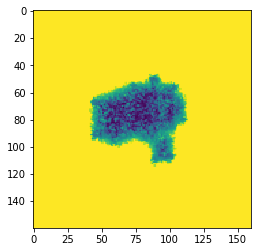

In [231]:
plt.imshow(X[0,:,:,0])
plt.show()

# 3. Convolitional Single Shot Detection network for phase classification

In [91]:
# imports
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [125]:
# Training parameters
batch_size = 64  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = False
num_classes = 13

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

In [126]:
# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 5

In [127]:
# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [95]:
X = np.asarray(X, dtype=np.float32)

In [232]:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [233]:
x_train.shape

(48000, 160, 160, 1)

In [234]:
y_train.shape

(48000, 1664)

In [235]:
x_test.shape

(12000, 160, 160, 1)

In [236]:
y_test.shape

(12000, 1664)

In [99]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train/255
x_test = x_test/255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (48000, 160, 160, 1)
48000 train samples
12000 test samples
y_train shape: (48000,)


In [133]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'phase_diagram_58_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [134]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [19]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3300/3300 [==============================] - 51s 16ms/step
Test loss: 5.4933937072753904
Test accuracy: 0.4163636363636364


In [136]:
input_shape

(160, 160, 1)

In [287]:
from keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, Reshape, Dropout, BatchNormalization
from keras.models import Model


grid_h = 1
grid_w = 1
other_dim = 13

i = Input(shape=input_shape)
x = Conv2D(16, (1, 1))(i)
x = Conv2D(128, (6, 6), strides=2)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (6, 6), strides=2)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (6, 6), strides=2)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)
x = BatchNormalization()(x)

x = Conv2D(26, (2, 2))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)

x = Conv2D(26, (2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)

x = Conv2D(26, (2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)

x = Conv2D(26, (2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)

x = Conv2D(26, (2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)

x = Conv2D(26, (2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.05)(x)

x = Conv2D(26, (2, 2), padding='same', activation='sigmoid')(x)
x = Flatten()(x)
model = Model(i, x)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 160, 160, 1)       0         
_________________________________________________________________
conv2d_824 (Conv2D)          (None, 160, 160, 16)      32        
_________________________________________________________________
conv2d_825 (Conv2D)          (None, 78, 78, 128)       73856     
_________________________________________________________________
leaky_re_lu_382 (LeakyReLU)  (None, 78, 78, 128)       0         
_________________________________________________________________
dropout_146 (Dropout)        (None, 78, 78, 128)       0         
_________________________________________________________________
batch_normalization_201 (Bat (None, 78, 78, 128)       512       
_________________________________________________________________
conv2d_826 (Conv2D)          (None, 76, 76, 64)        73792     
__________

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 2e-9
    if epoch >= 8:
        lr *= 0.5e-3
    elif epoch >= 7:
        lr *= 1e-3
    elif epoch >= 5:
        lr *= 1e-2
    elif epoch >= 3:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=1,
                               min_lr=0.5e-8)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

batch_size = 100
epochs = 10

#train the model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

In [303]:
x_test.shape

(12000, 160, 160, 1)

In [304]:
X.shape

(60000, 160, 160, 1)

In [302]:
y_labels.shape

(60000, 1664)

# 4. Estimation of phase diagram

Final model name 'phase_diagram_58_ResNet32v1_model.005.h5'

In [464]:
y_pred = model.predict(X)

In [389]:
labels[1232]

array([ 4.2945, -4.6557])

In [390]:
voronoi_points.reshape(-1,2)[np.argmax(y_pred[1232])]

array([5.22767, 2.61634])

In [406]:
y_pred

array([[0.04976, 0.0592 , 0.04371, ..., 0.03315, 0.0147 , 0.19165],
       [0.0395 , 0.13889, 0.07525, ..., 0.13246, 0.01591, 0.31339],
       [0.14099, 0.04014, 0.03217, ..., 0.03865, 0.0063 , 0.03585],
       ...,
       [0.00265, 0.45314, 0.43528, ..., 0.00577, 0.00532, 0.1074 ],
       [0.11115, 0.01368, 0.02812, ..., 0.01322, 0.06965, 0.00775],
       [0.13465, 0.02015, 0.03275, ..., 0.00755, 0.00857, 0.01186]],
      dtype=float32)

In [428]:
def get_label(labels_idx, voronoi_idx):
    return np.argmin((labels[labels_idx,0]-voronoi_points[voronoi_idx,:,0])**2+
                     (labels[labels_idx,1]-voronoi_points[voronoi_idx,:,1])**2)

In [429]:
get_label(0,0)

5

In [431]:
voronoi_points[0][5]

array([2.85368, 3.85808])

In [432]:
labels[0]

array([2.3478, 3.0711])

In [436]:
y_labels[0].reshape()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [408]:
%%time
import umap
from sklearn.datasets import load_digits

embedding = umap.UMAP(verbose=True).fit_transform(y_pred)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Mon Nov 25 04:17:21 2019 Finding Nearest Neighbors
Mon Nov 25 04:17:21 2019 Building RP forest with 10 trees
Mon Nov 25 04:17:22 2019 NN descent for 14 iterations


C:\deeplearning\envs\PythonGPU\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\deeplearning\envs\PythonGPU\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


	 0  /  14
	 1  /  14
	 2  /  14
Mon Nov 25 04:17:26 2019 Finished Nearest Neighbor Search
Mon Nov 25 04:17:26 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 25 04:17:35 2019 Finished embedding
Wall time: 14.1 s


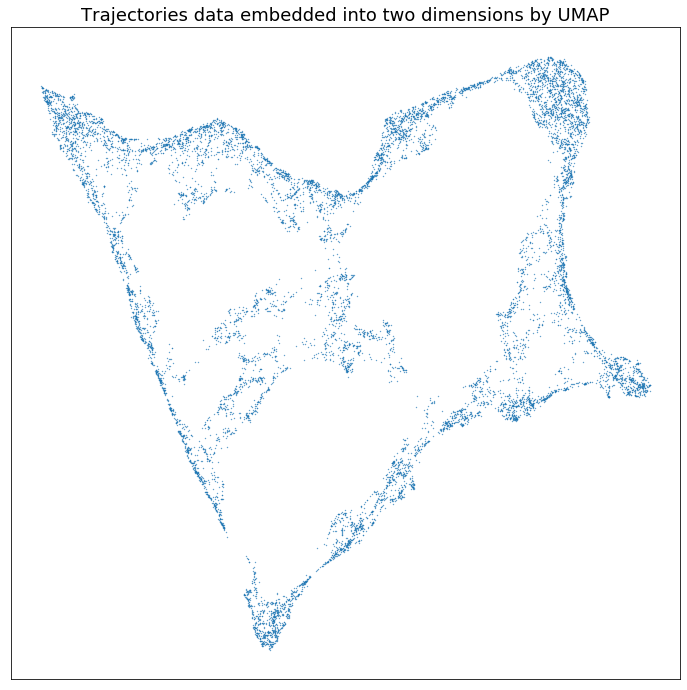

In [409]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.scatter(
    embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1
)

plt.setp(ax, xticks=[], yticks=[])
plt.title("Trajectories data embedded into two dimensions by UMAP", fontsize=18)
plt.show()

In [469]:
y_pred[INDEX_pred].reshape(-1, 128)[:,0]/(y_pred[INDEX_pred].reshape(-1, 128)[:,0]).sum()

array([1.13940e-01, 1.65153e-01, 9.81770e-02, 9.74035e-03, 4.81736e-03,
       3.89683e-04, 1.40835e-04, 6.25495e-03, 2.04373e-03, 5.20626e-02,
       4.32784e-01, 1.11668e-01, 2.82736e-03], dtype=float32)

In [528]:
np.save('y_predicted_features_of_trajectories_(y_pred)', y_pred)

In [529]:
np.save('labels_of_trajectories_(labels)', labels)

In [477]:
labels[INDEX_pred]

array([-2.5095,  1.9264])

In [505]:
INDEX_pred = 1277
point_prediction = np.zeros((len(voronoi_points), 2))
confidence = []
for tidz in range(len(voronoi_points)):
    point_prediction[tidz] = y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]/(y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]).sum()@voronoi_points[tidz]
    confidence.append(np.max(y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]))
print('pred',point_prediction[np.argmax(confidence)])
print('true',labels[INDEX_pred])

pred [1.78936 0.27854]
true [-3.436   2.0624]


In [500]:
point_prediction[np.argmax(confidence)]

array([-2.22628, -2.16914])

In [496]:
np.max(y_pred[INDEX_pred].reshape(-1, 128)[:,tidz])

0.60247433

In [880]:
total_prediction = np.zeros((len(y_pred), 2))
from progressbar import ProgressBar

pbar = ProgressBar()

for INDEX_pred in pbar(range(len(y_pred))):
    point_prediction = np.zeros((len(voronoi_points), 2))
    confidence = []
    for tidz in range(len(voronoi_points)):
        point_prediction[tidz] = y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]/(y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]).sum()@voronoi_points[tidz]
        confidence.append(np.max(y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]))
    total_prediction[INDEX_pred] = point_prediction.T@np.array(confidence)/np.array(confidence).sum()

100% |########################################################################|


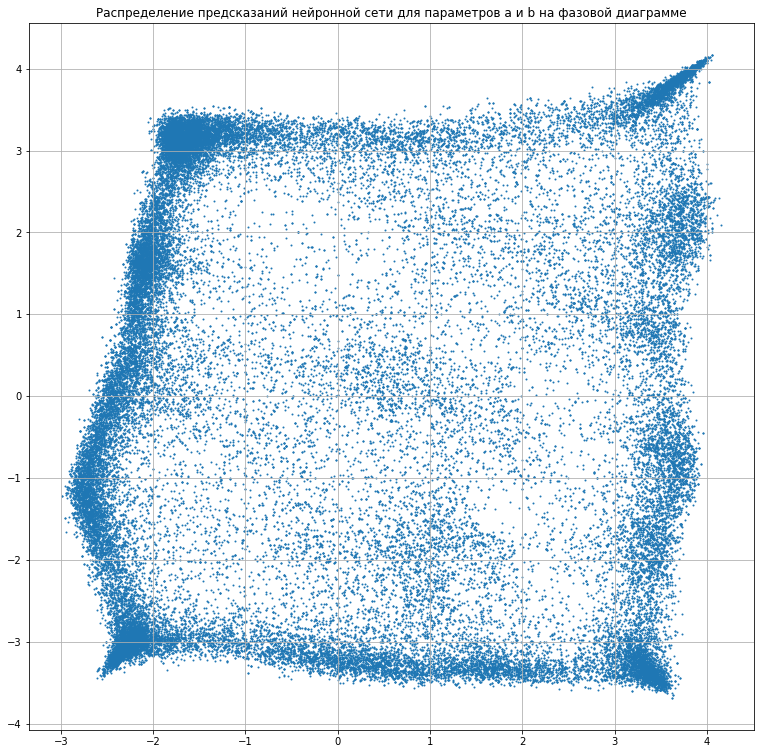

In [881]:
plt.figure(figsize=(13,13))
plt.scatter(total_prediction[:,0], total_prediction[:,1], s=1)
plt.grid();
plt.title("Распределение предсказаний нейронной сети для параметров a и b на фазовой диаграмме");

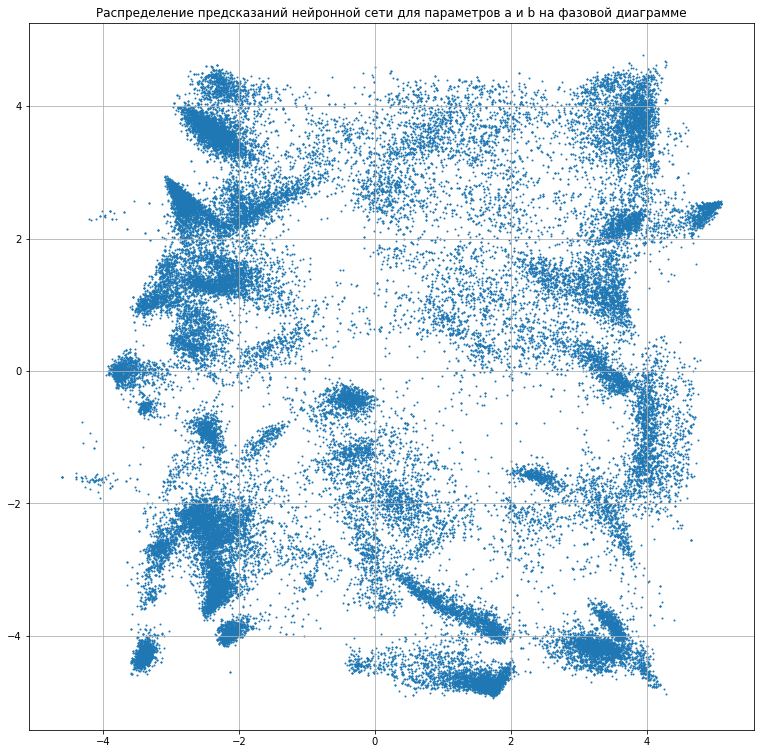

In [530]:
# Если взять только самое уверенное предсказание, то мы видим эффекты разбиения на области Вороного
plt.figure(figsize=(13,13))
plt.scatter(total_prediction[:,0], total_prediction[:,1], s=1)
plt.grid();
plt.title("Распределение предсказаний нейронной сети для параметров a и b на фазовой диаграмме");

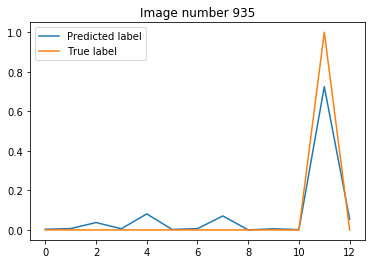

In [925]:
INDEX_pred = np.random.randint(0, len(y_pred))
plt.plot(y_pred[INDEX_pred].reshape(-1, 128)[:,126]/(y_pred[INDEX_pred].reshape(-1, 128)[:,126]).sum())
plt.plot(y_labels[INDEX_pred].reshape(-1, 128)[:,126])
plt.legend(['Predicted label', 'True label']);
plt.title("Image number {}".format(INDEX_pred));

In [982]:
embedding = np.copy(total_prediction)

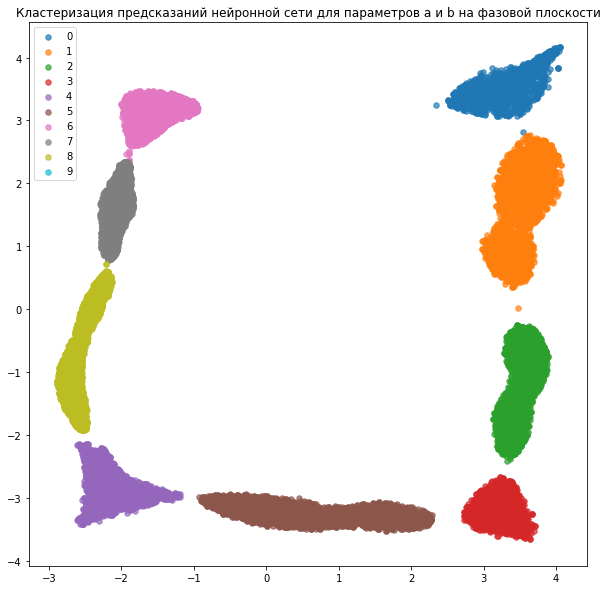

In [983]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering as kcl

Data = {'x': embedding[::,0],
        'y': embedding[::,1]
       }

df = DataFrame(Data,columns=['x','y'])

import hdbscan

labels_q_ = hdbscan.HDBSCAN(
    min_samples=400,
    min_cluster_size=2000,
).fit_predict(embedding)

def plt_cls(idx):
    t = embedding[labels_q_==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.7, s=30, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
plt.legend(labels__);
plt.title('Кластеризация предсказаний нейронной сети для параметров a и b на фазовой плоскости');

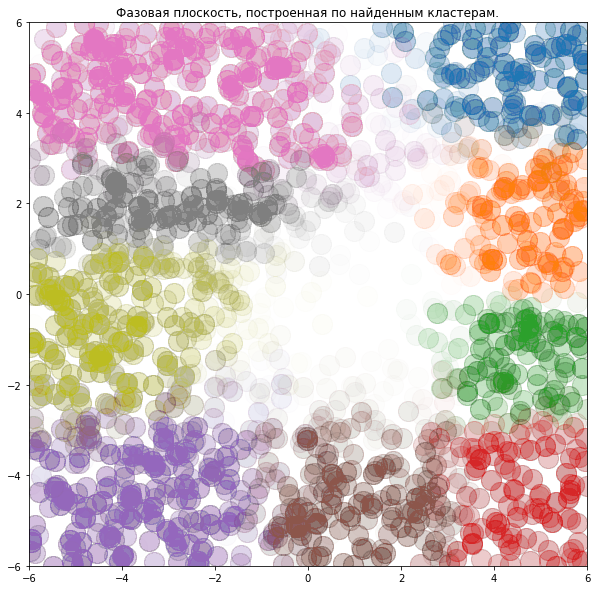

In [984]:
def plt_cls(idx):
    t = labels[labels_q_==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.01, s=406, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
#plt.legend(labels__)
plt.xlim((-6,6))
plt.ylim((-6,6));
plt.title('Фазовая плоскость, построенная по найденным кластерам.');

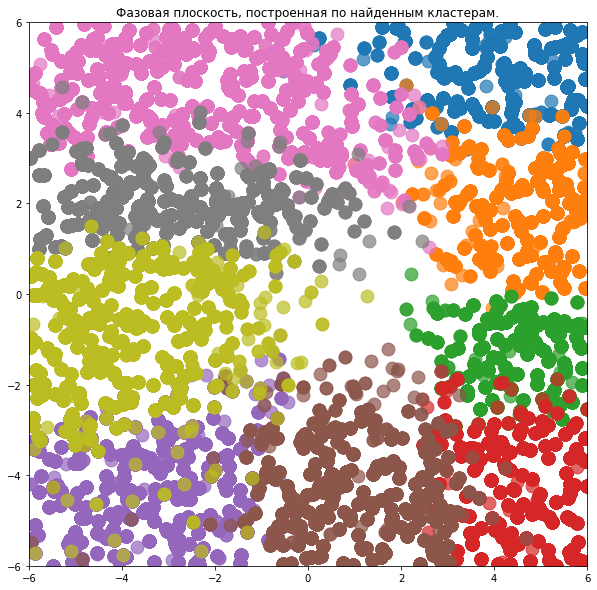

In [985]:
def plt_cls(idx):
    t = labels[labels_q_==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.71, s=166, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
#plt.legend(labels__)
plt.xlim((-6,6))
plt.ylim((-6,6));
plt.title('Фазовая плоскость, построенная по найденным кластерам.');

# 5. Construct phase diagram using independently generated set of images

In [14]:
validation_images_filenames = ! dir "Scripts for image generation"

In [15]:
validation_images_filenames = [_[len('24.11.2019  19:45            50я636 '):] for _ in validation_images_filenames if ('.png' in _)]

In [16]:
print(len(validation_images_filenames))

35584


In [17]:
validation_images_labels = []
for __ in range(len(validation_images_filenames)):
    if ('fig_[' in validation_images_filenames[__]):
        if (']_azim_' in validation_images_filenames[__]):
            try:
                validation_images_labels.append(validation_images_filenames[__].split('fig_[')[-1].split(']_azim_')[0].strip())
            except:
                print('Error', __)

import numpy as np
np.set_printoptions(precision=5)

validation_images_labels_vq = []
for ooo in range(len(validation_images_labels)):
    validation_images_labels_vq.append([float(TY) for TY in validation_images_labels[ooo].split(' ') if len(TY)>1])
    
validation_images_labels = np.array(validation_images_labels_vq)

In [18]:
import keras

def get_image(image_idx):
    pil_im = Image.open('Scripts for image generation/'+validation_images_filenames[image_idx])
    pil_im.thumbnail((IMAGE_SIZE, IMAGE_SIZE))
    pil_im = pil_im.convert('L')
    res_numpy = np.array(pil_im, dtype=np.float32)[PADDING:-PADDING,PADDING:-PADDING]/255
    pil_im.close()
    return res_numpy.reshape(res_numpy.shape[0], res_numpy.shape[1], 1)
get_image = np.vectorize(get_image)

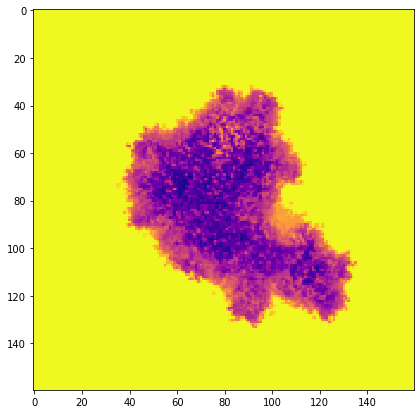

In [19]:
pil_im = get_image(9445)[:,:,0]
plt.figure(figsize=(7,7))
plt.imshow(pil_im, cmap='plasma')
plt.show();

In [20]:
%%time
validation_images_X = np.zeros((len(validation_images_labels), IMAGE_SIZE-2*PADDING, IMAGE_SIZE-2*PADDING, 1), dtype = np.float32)
from progressbar import ProgressBar
pbar = ProgressBar()

for i in pbar(range(len(validation_images_labels))):
    validation_images_X[i] = get_image(i)
np.save('validation_images_X', validation_images_X)

100% |########################################################################|


Wall time: 35min 48s


In [26]:
validation_images_X.shape

(35584, 160, 160, 1)

In [22]:
validation_images_y_pred = model.predict(255*validation_images_X)

In [31]:
%%time
num_classes = 13

validation_images_y_labels = np.zeros((len(validation_images_labels), num_classes, len(voronoi_points)), dtype=np.float32)

def get_label(labels_idx, voronoi_idx):
    return np.argmin((validation_images_labels[labels_idx,0]-voronoi_points[voronoi_idx,:,0])**2+
                     (validation_images_labels[labels_idx,1]-voronoi_points[voronoi_idx,:,1])**2)

from progressbar import ProgressBar
pbar = ProgressBar()

for voronoi_idx in pbar(range(len(voronoi_points))):
    y = np.zeros(len(validation_images_labels))
    

    
    for i in range(len(validation_images_labels)):
        y[i] = get_label(i, voronoi_idx)
    
    validation_images_y_labels[:,:,voronoi_idx] = keras.utils.to_categorical(y, num_classes)

Wall time: 41.1 s


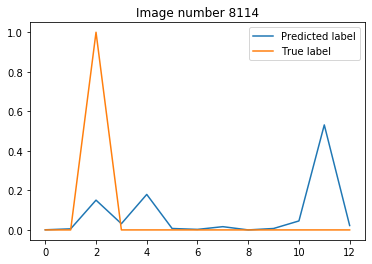

In [33]:
INDEX_pred = np.random.randint(0, len(validation_images_y_pred))
plt.plot(validation_images_y_pred[INDEX_pred].reshape(-1, 128)[:,126]/(validation_images_y_pred[INDEX_pred].reshape(-1, 128)[:,126]).sum())
plt.plot(validation_images_y_labels[INDEX_pred].reshape(-1, 128)[:,126])
plt.legend(['Predicted label', 'True label']);
plt.title("Image number {}".format(INDEX_pred));

In [34]:
%%time
validation_images_total_prediction = np.zeros((len(validation_images_y_pred), 2))
from progressbar import ProgressBar

pbar = ProgressBar()

for INDEX_pred in pbar(range(len(validation_images_y_pred))):
    point_prediction = np.zeros((len(voronoi_points), 2))
    confidence = []
    for tidz in range(len(voronoi_points)):
        point_prediction[tidz] = validation_images_y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]/(validation_images_y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]).sum()@voronoi_points[tidz]
        confidence.append(np.max(validation_images_y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]))
        # 32 самых неуверенных прогноза
    validation_images_total_prediction[INDEX_pred] = point_prediction.T@np.array(confidence)/np.array(confidence).sum()

Wall time: 1min 15s


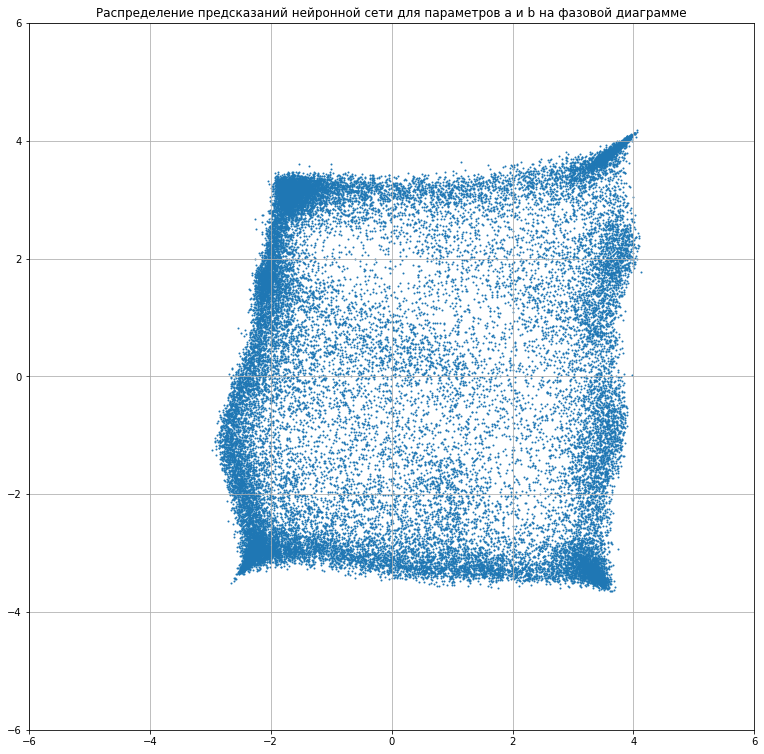

In [35]:
plt.figure(figsize=(13,13))
plt.scatter(validation_images_total_prediction[:,0], validation_images_total_prediction[:,1], s=1)
plt.grid();
plt.title("Распределение предсказаний нейронной сети для параметров a и b на фазовой диаграмме");
plt.xlim((-6,6))
plt.ylim((-6,6));

In [36]:
embedding = np.copy(validation_images_total_prediction)

In [37]:
len(embedding)

35584

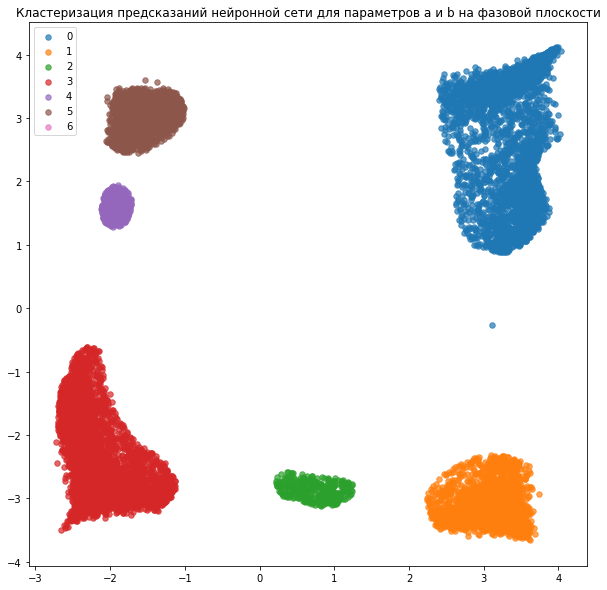

In [83]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering as kcl

Data = {'x': embedding[::,0],
        'y': embedding[::,1]
       }

df = DataFrame(Data,columns=['x','y'])

import hdbscan

labels_q_ = hdbscan.HDBSCAN(
    min_samples=1800,
    min_cluster_size=200,
).fit_predict(validation_images_total_prediction)

def plt_cls(idx):
    t = validation_images_total_prediction[labels_q_==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.7, s=30, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
plt.legend(labels__);
plt.title('Кластеризация предсказаний нейронной сети для параметров a и b на фазовой плоскости');

In [84]:
len(labels_q_)

35584

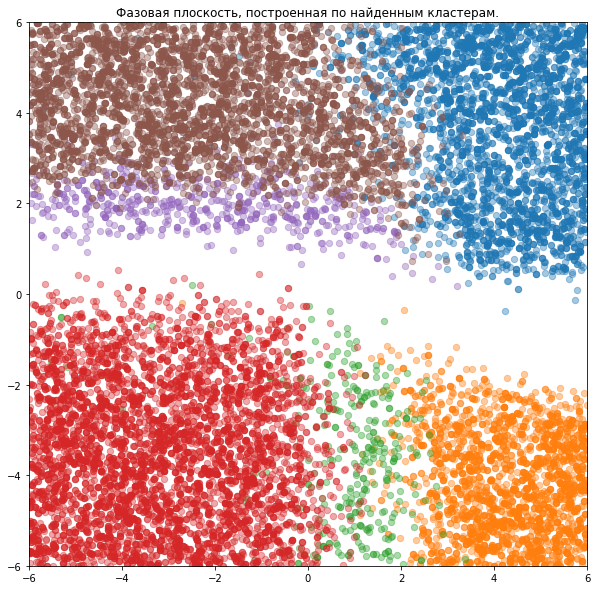

In [85]:
def plt_cls(idx):
    t = validation_images_labels[labels_q_==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.4, s=40, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
#plt.legend(labels__)
plt.xlim((-6,6))
plt.ylim((-6,6));
plt.title('Фазовая плоскость, построенная по найденным кластерам.');

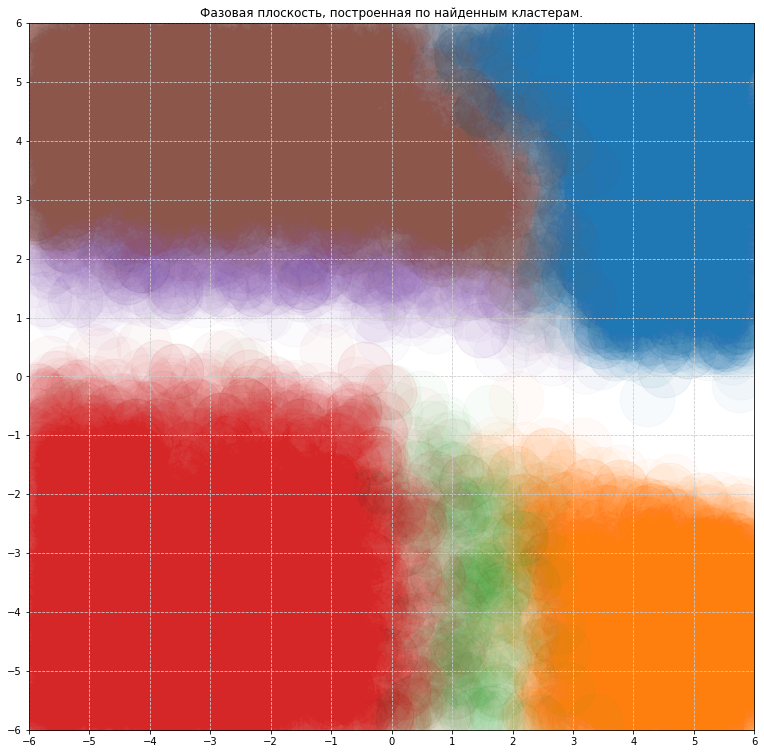

In [87]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(13, 13))

def plt_cls(idx):
    t = validation_images_labels[labels_q_==idx]
    ax.scatter(t[:,0], t[:,1], alpha=0.03, s=3000, label=idx)

for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
    
    
# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.title('Фазовая плоскость, построенная по найденным кластерам.');
# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.5))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

# 6. Distribution of predictions for the point {a: 2 = exp(0.7), b: 2 = exp(0.7)}.

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.models import load_model

In [3]:
model = load_model('saved_models/phase_diagram_58_ResNet32v1_model.083.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [10]:
dist_around_point_files = ! dir Phase_distribution_around_point

In [11]:
dist_around_point_filenames = [_[len('24.11.2019  19:45            50я636 '):] for _ in dist_around_point_files if ('.png' in _)]

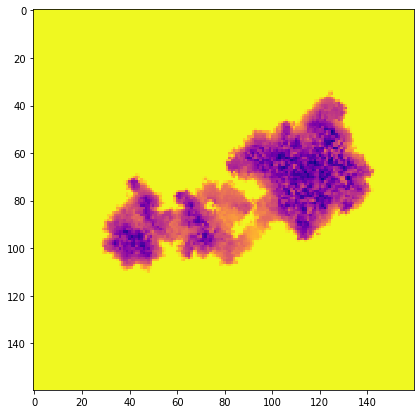

In [12]:
from PIL import Image

IMAGE_SIZE = 300
PADDING = 70

def get_image(image_idx):
    pil_im = Image.open('Phase_distribution_around_point/'+dist_around_point_filenames[image_idx])
    pil_im.thumbnail((IMAGE_SIZE, IMAGE_SIZE))
    pil_im = pil_im.convert('L')
    res_numpy = np.array(pil_im, dtype=np.float32)[PADDING:-PADDING,PADDING:-PADDING]/255
    pil_im.close()
    return res_numpy.reshape(res_numpy.shape[0], res_numpy.shape[1], 1)
get_image = np.vectorize(get_image)

pil_im = get_image(5)[:,:,0]
plt.figure(figsize=(7,7))
plt.imshow(pil_im, cmap='plasma')
plt.show();

In [11]:
%%time
dist_around_point_images_X = np.zeros((len(dist_around_point_filenames), IMAGE_SIZE-2*PADDING, IMAGE_SIZE-2*PADDING, 1), dtype = np.float32)
from progressbar import ProgressBar
pbar = ProgressBar()

for i in pbar(range(len(dist_around_point_filenames))):
    dist_around_point_images_X[i] = get_image(i)

Wall time: 7min 27s


In [12]:
dist_around_point_images_X.shape

(9347, 160, 160, 1)

In [13]:
y_pred = np.load('y_predicted_features_of_trajectories_(y_pred).npy')

In [14]:
dist_around_point_y_pred = model.predict(255*dist_around_point_images_X)

In [16]:
voronoi_files = ! dir Voronoi_diagrams
voronoi_files = [_.split('           ')[-1][8:] for _ in voronoi_files if ('.png' in _)]
voronoi_points = np.load('Voronoi_diagrams/production_points.npy')

In [17]:
%time
total_prediction = np.zeros((len(y_pred), 2))
from progressbar import ProgressBar

pbar = ProgressBar()

for INDEX_pred in pbar(range(len(y_pred))):
    point_prediction = np.zeros((len(voronoi_points), 2))
    confidence = []
    for tidz in range(len(voronoi_points)):
        point_prediction[tidz] = y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]/(y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]).sum()@voronoi_points[tidz]
        confidence.append(np.max(y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]))
    total_prediction[INDEX_pred] = point_prediction.T@np.array(confidence)/np.array(confidence).sum()

Wall time: 0 ns


100% |########################################################################|


In [18]:
%%time
dist_around_point_total_prediction = np.zeros((len(dist_around_point_y_pred), 2))
from progressbar import ProgressBar

pbar = ProgressBar()

for INDEX_pred in pbar(range(len(dist_around_point_y_pred))):
    point_prediction = np.zeros((len(voronoi_points), 2))
    confidence = []
    for tidz in range(len(voronoi_points)):
        point_prediction[tidz] = dist_around_point_y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]/(dist_around_point_y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]).sum()@voronoi_points[tidz]
        confidence.append(np.max(dist_around_point_y_pred[INDEX_pred].reshape(-1, 128)[:,tidz]))
    dist_around_point_total_prediction[INDEX_pred] = point_prediction.T@np.array(confidence)/np.array(confidence).sum()

Wall time: 16 s


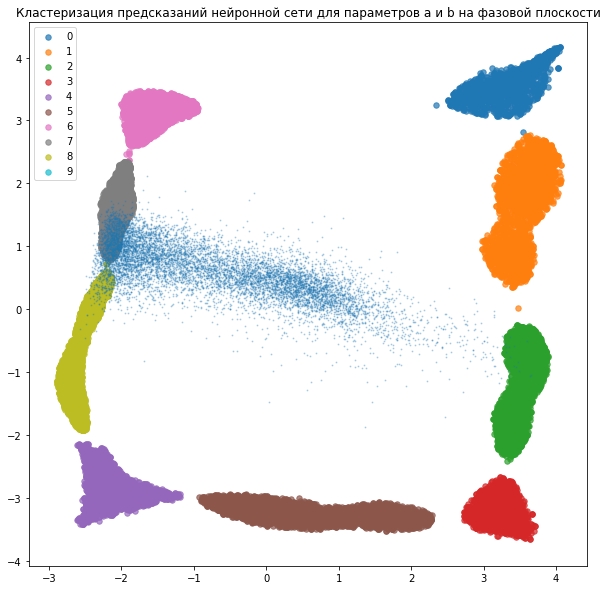

In [21]:
embedding = np.copy(total_prediction)

from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering as kcl

Data = {'x': embedding[::,0],
        'y': embedding[::,1]
       }

df = DataFrame(Data,columns=['x','y'])

import hdbscan

labels_q_ = hdbscan.HDBSCAN(
    min_samples=400,
    min_cluster_size=2000,
).fit_predict(embedding)

def plt_cls(idx):
    t = embedding[labels_q_==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.7, s=30, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
plt.legend(labels__);

plt.scatter(dist_around_point_total_prediction[:,0], dist_around_point_total_prediction[:,1], s=1, alpha=0.25, c='blue')

plt.title('Кластеризация предсказаний нейронной сети для параметров a и b на фазовой плоскости');

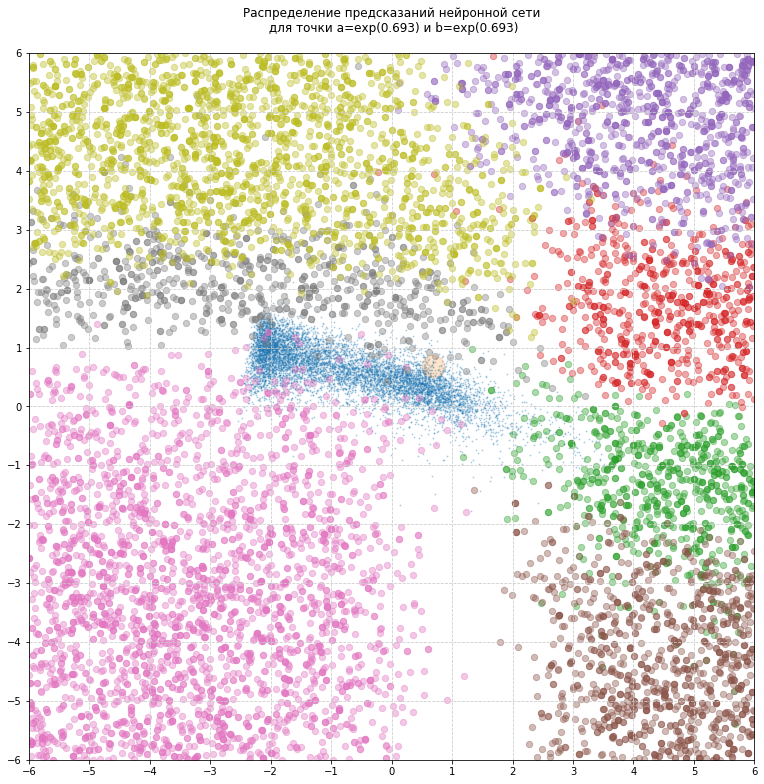

In [1002]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(13, 13))
ax.scatter(dist_around_point_total_prediction[:,0], dist_around_point_total_prediction[:,1], s=1, alpha=0.25)
ax.scatter(0.69, 0.69, s=500, alpha=0.2)
# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.title("Распределение предсказаний нейронной сети\n для точки a=exp(0.693) и b=exp(0.693)\n");
# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.5))

def plt_cls(idx):
    t = validation_images_labels[labels_q_==idx]
    ax.scatter(t[:,0], t[:,1], alpha=0.4, s=40, label=idx)

for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

# 7. Distribution of predictions for the point {a: 7.3 = exp(2),  b: 20.0 = exp(3)}

In [23]:
dist_around_point_files_2 = ! dir Phase_distribution_around_point_2

In [24]:
dist_around_point_filenames_2 = [_[len('24.11.2019  19:45            50я636 '):] for _ in dist_around_point_files_2 if ('.png' in _)]
len(dist_around_point_filenames_2)

5391

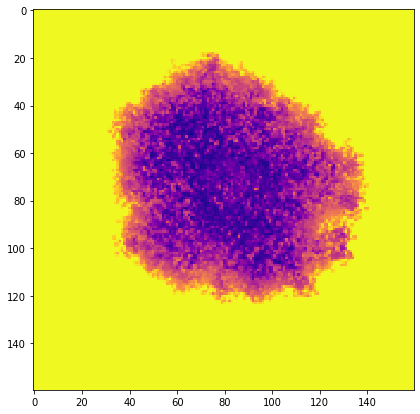

In [25]:
import keras

def get_image(image_idx):
    pil_im = Image.open('Phase_distribution_around_point_2/'+dist_around_point_filenames_2[image_idx])
    pil_im.thumbnail((IMAGE_SIZE, IMAGE_SIZE))
    pil_im = pil_im.convert('L')
    res_numpy = np.array(pil_im, dtype=np.float32)[PADDING:-PADDING,PADDING:-PADDING]/255
    pil_im.close()
    return res_numpy.reshape(res_numpy.shape[0], res_numpy.shape[1], 1)
get_image = np.vectorize(get_image)

pil_im = get_image(5)[:,:,0]
plt.figure(figsize=(7,7))
plt.imshow(pil_im, cmap='plasma')
plt.show();

In [26]:
%%time
dist_around_point_images_X_2 = np.zeros((len(dist_around_point_filenames_2), IMAGE_SIZE-2*PADDING, IMAGE_SIZE-2*PADDING, 1), dtype = np.float32)
from progressbar import ProgressBar
pbar = ProgressBar()

for i in pbar(range(len(dist_around_point_filenames_2))):
    dist_around_point_images_X_2[i] = get_image(i)

Wall time: 4min 32s


In [27]:
dist_around_point_images_X_2.shape

(5391, 160, 160, 1)

In [28]:
dist_around_point_y_pred_2 = model.predict(255*dist_around_point_images_X_2)

In [29]:
%%time
dist_around_point_total_prediction_2 = np.zeros((len(dist_around_point_y_pred_2), 2))
from progressbar import ProgressBar

pbar = ProgressBar()

for INDEX_pred in pbar(range(len(dist_around_point_y_pred_2))):
    point_prediction = np.zeros((len(voronoi_points), 2))
    confidence = []
    for tidz in range(len(voronoi_points)):
        point_prediction[tidz] = dist_around_point_y_pred_2[INDEX_pred].reshape(-1, 128)[:,tidz]/(dist_around_point_y_pred_2[INDEX_pred].reshape(-1, 128)[:,tidz]).sum()@voronoi_points[tidz]
        confidence.append(np.max(dist_around_point_y_pred_2[INDEX_pred].reshape(-1, 128)[:,tidz]))
    dist_around_point_total_prediction_2[INDEX_pred] = point_prediction.T@np.array(confidence)/np.array(confidence).sum()

Wall time: 11.1 s


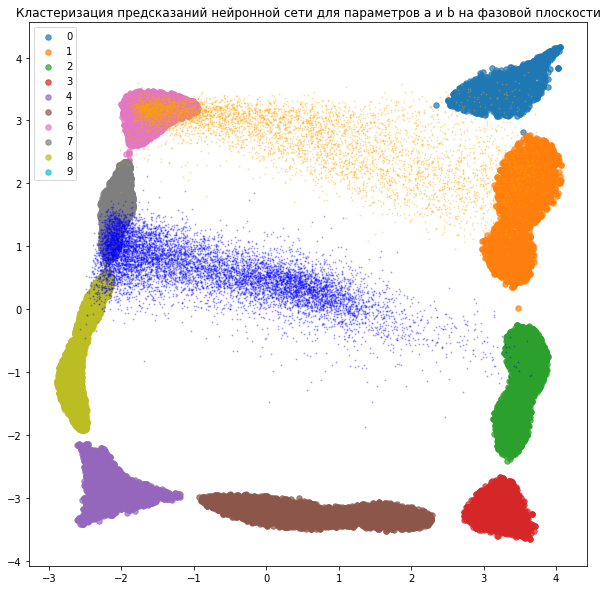

In [31]:
embedding = np.copy(total_prediction)

from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering as kcl

Data = {'x': embedding[::,0],
        'y': embedding[::,1]
       }

df = DataFrame(Data,columns=['x','y'])

import hdbscan

labels_q_ = hdbscan.HDBSCAN(
    min_samples=400,
    min_cluster_size=2000,
).fit_predict(embedding)

def plt_cls(idx):
    t = embedding[labels_q_==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.7, s=30, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
plt.legend(labels__);

plt.scatter(dist_around_point_total_prediction_2[:,0], dist_around_point_total_prediction_2[:,1], s=1, alpha=0.25, c='orange')
plt.scatter(dist_around_point_total_prediction[:,0], dist_around_point_total_prediction[:,1], s=1, alpha=0.25, c='blue')

plt.title('Кластеризация предсказаний нейронной сети для параметров a и b на фазовой плоскости');

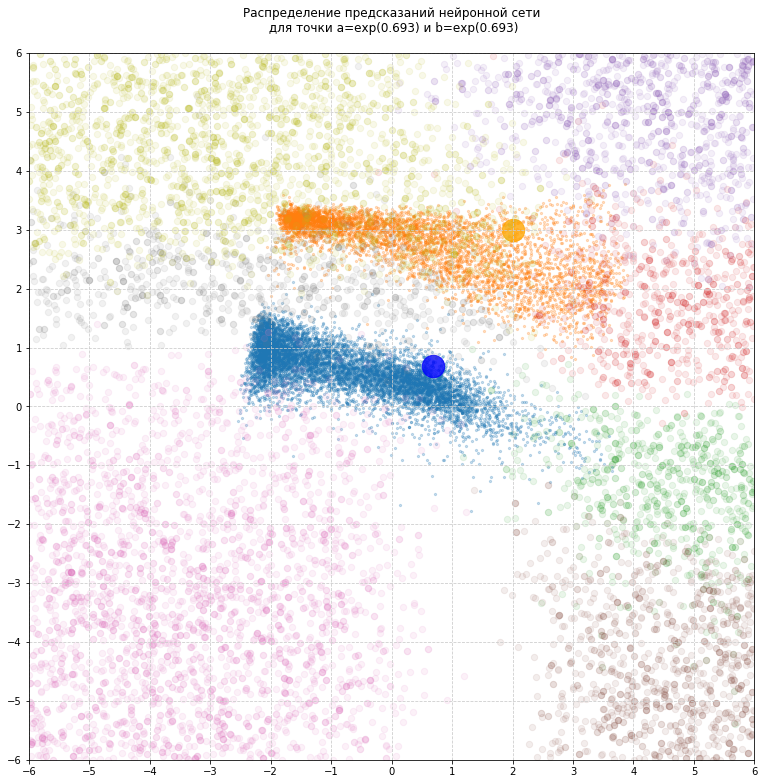

In [1183]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(13, 13))
ax.scatter(dist_around_point_total_prediction[:,0], dist_around_point_total_prediction[:,1], s=5, alpha=0.25)
ax.scatter(dist_around_point_total_prediction_2[:,0], dist_around_point_total_prediction_2[:,1], s=5, alpha=0.25)
ax.scatter(2, 3, s=500, alpha=0.8, c='orange')
ax.scatter(0.69, 0.69, s=500, alpha=0.8, c='blue')
# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.title("Распределение предсказаний нейронной сети\n для точки a=exp(0.693) и b=exp(0.693)\n");
# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.5))

def plt_cls(idx):
    t = validation_images_labels[labels_q_==idx]
    ax.scatter(t[:,0], t[:,1], alpha=0.1, s=40, label=idx)

for i in range(len(set(labels_q_))):
    plt_cls(i)
    labels__.append(str(i))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')